<a href="https://colab.research.google.com/github/cchummer/ml-dl-scratch/blob/main/CLIP_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CLIP implementation inspired by [these](https://keras.io/examples/vision/nl_image_search/) [two](https://towardsdatascience.com/simple-implementation-of-openai-clip-model-a-tutorial-ace6ff01d9f2) articles, using a pretrained image encoder and text encoder.

In [1]:
import pandas as pd
import numpy as np
import torch
import itertools
from torch import nn
from torchvision import models
import torch.nn.functional as F
import albumentations as A
import matplotlib.pyplot as plt
import cv2
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Preprocessing, only need to run once
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML+DL/Flickr8k/captions.txt')
df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)] # Deal with format of dataset (5 captions per image)
df.to_csv('/content/drive/My Drive/Colab Notebooks/ML+DL/Flickr8k/captions.csv', index=False)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML+DL/Flickr8k/captions.csv')

In [3]:
# Variables needed throughout the models
image_path = '/content/drive/My Drive/Colab Notebooks/ML+DL/Flickr8k/Images'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_model_name = 'resnet50'
text_encoder_model = "distilbert-base-uncased"
text_tokenizer = "distilbert-base-uncased"
tokenizer_max_len = 200
trans_img_size = 224
batch_size = 32
num_workers = 2
proj_dim_size = 256
proj_dropout = 0.1
image_embedding_size = 2048
text_embedding_size = 768
image_encoder_lr = 0.0001
text_encoder_lr = 0.00001
head_lr = 0.001
weight_decay = 0.001
scheduler_factor = 0.5
scheduler_patience = 2

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML+DL/Flickr8k/captions.csv')
df

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,8090
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,8090
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,8090
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,8090


# Dataset + Dataloaders

In [5]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and captions must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=tokenizer_max_len
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item

    def __len__(self):
        return len(self.captions)

In [6]:
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                # Consider adding more augmentations for training
                A.Resize(trans_img_size, trans_img_size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(trans_img_size, trans_img_size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [7]:
def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [8]:
def make_train_valid_dfs(dataframe):
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

# Models: Image + Text Encoders, Contrastive Learner

In [9]:
class ImageEncoder(nn.Module):
    def __init__(
        self, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()

        # Load the pre-trained model
        self.model = getattr(models, model_name)(pretrained=pretrained)

        # Remove the final classification layer
        self.model = nn.Sequential(*list(self.model.children())[:-1])

        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        x = self.model(x)
        # Flatten the output to get a fixed size vector
        return x.view(x.size(0), -1)

In [10]:
class TextEncoder(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # We are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [11]:
# The projection head is used to project embeddings into tensors of the same size, so they can be compared
# Image encoder and text encoder return tensors/embeddings of different sizes, so pass their outputs through the projection head
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=proj_dim_size,
        dropout=proj_dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [12]:
def cross_entropy(preds, targets, reduction='none'):
  log_softmax = nn.LogSoftmax(dim=-1)
  loss = (-targets * log_softmax(preds)).sum(1)
  if reduction == "none":
      return loss
  elif reduction == "mean":
      return loss.mean()


class CLIPModel(nn.Module):
  def __init__(
      self,
      temperature=1,
      image_embedding=image_embedding_size,
      text_embedding=text_embedding_size,
  ):
    super().__init__()
    self.image_encoder = ImageEncoder()
    self.text_encoder = TextEncoder()
    self.image_projection = ProjectionHead(embedding_dim=image_embedding)
    self.text_projection = ProjectionHead(embedding_dim=text_embedding)
    self.temperature = temperature

  def forward(self, batch):
    # Getting Image and Text Features
    image_features = self.image_encoder(batch["image"])
    text_features = self.text_encoder(
        input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
    )

    # Getting Image and Text Embeddings (with same dimension)
    image_embeddings = self.image_projection(image_features)
    text_embeddings = self.text_projection(text_features)

    # Calculating the Loss
    logits = (text_embeddings @ image_embeddings.T) / self.temperature

    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T

    targets = F.softmax(
        (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
    )

    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
    return loss.mean()

# Training

In [13]:
class AvgMeter:
  def __init__(self, name="Metric"):
    self.name = name
    self.reset()

  def reset(self):
    self.avg, self.sum, self.count = [0] * 3

  def update(self, val, count=1):
    self.count += count
    self.sum += val * count
    self.avg = self.sum / self.count

  def __repr__(self):
    text = f"{self.name}: {self.avg:.4f}"
    return text

In [14]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    i_batch = 0
    for i, batch in enumerate(train_loader):

        print(f"Batch {i + 1} / {len(train_loader)}")

        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}

        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

    return loss_meter

def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    for batch in valid_loader:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

    return loss_meter

def training_loop(df, num_epochs):

    train_df, valid_df = make_train_valid_dfs(df)
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": head_lr, "weight_decay": weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=scheduler_patience, factor=scheduler_factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()

        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)

        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
            print(f"Train Loss: {train_loss}")
            print(f"Valid Loss: {valid_loss}")

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

In [ ]:
training_loop(df, 5)

# Inference

In [15]:
# My trained model/weights
saved_trained_path = '/content/drive/My Drive/Colab Notebooks/ML+DL/Flickr8k/best.pt'

In [16]:
def get_image_embeddings(valid_df, model_path):
  tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)

  # Samples won't be shuffled when mode=valid
  # Thus the indices of the embeddings list returned should match the order of images/filenames in the validation dataframe
  valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

  model = CLIPModel().to(device)
  model.load_state_dict(torch.load(model_path, map_location=device))
  model.eval()

  valid_image_embeddings = []
  with torch.no_grad():
    for batch in valid_loader:

      image_features = model.image_encoder(batch["image"].to(device))
      image_embeddings = model.image_projection(image_features)
      valid_image_embeddings.append(image_embeddings)

  return model, torch.cat(valid_image_embeddings)

In [17]:
# First we grab the embeddings of all the images in our validation set
_, valid_df = make_train_valid_dfs(df)
model, valid_image_embeddings = get_image_embeddings(valid_df, saved_trained_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [18]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
  tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
  encoded_query = tokenizer([query])
  batch = {
      key: torch.tensor(values).to(device)
      for key, values in encoded_query.items()
  }
  with torch.no_grad():
    text_features = model.text_encoder(
        input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
    )
    text_embeddings = model.text_projection(text_features)

  image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
  text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
  dot_similarity = text_embeddings_n @ image_embeddings_n.T

  values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
  matches = [image_filenames[idx] for idx in indices[::5]]

  _, axes = plt.subplots(3, 3, figsize=(10, 10))
  for match, ax in zip(matches, axes.flatten()):
    image = cv2.imread(f"{image_path}/{match}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.axis("off")

  plt.show()

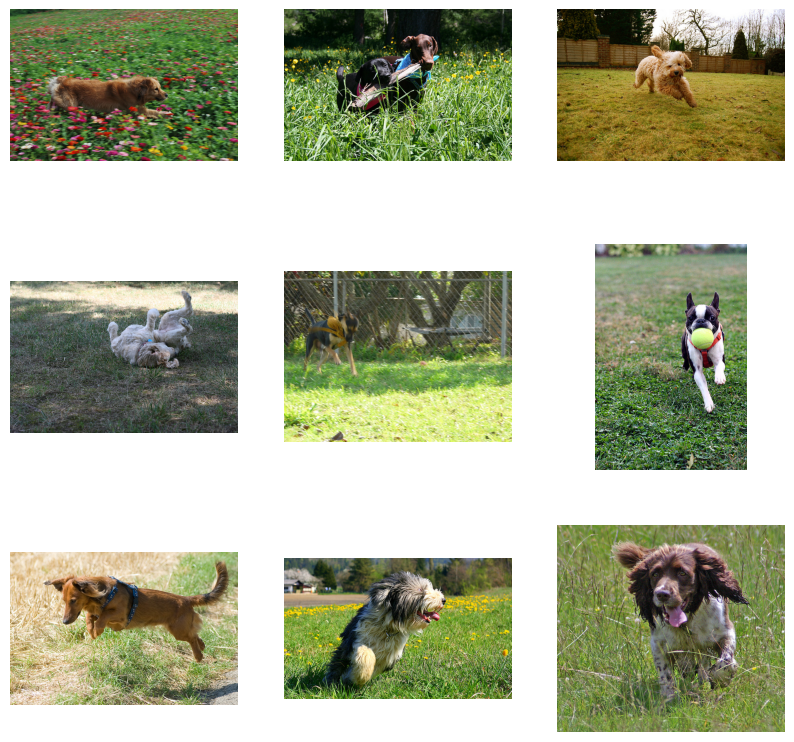

In [19]:
find_matches(model,
             valid_image_embeddings,
             query="a dog in grass",
             image_filenames=valid_df['image'].values,
             n=9)